# FFT sampling and averaging overview 
In this notebook, we will look at a noise signal and see how averaging can help us extract the amplitude of the signal with higher signal-to-noise. First, we need to generate a noisy signal. Here we generate a random frequency and amplitude, then delete the variables so we have to perform the FFT to extract their original values.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
fsample = 1000 # 1 kHz 
tsample = 1 / fsample
time = np.arange(0, 1, tsample)
frequency = np.random.uniform(0.1, 100)
amplitude = np.random.uniform(0.1, 10)
delta = 0
x = amplitude * np.sin(2 * np.pi * time * frequency + delta)
noise = 0.5 * amplitude * np.random.normal(0, 1, len(time))
x += noise
del frequency, amplitude

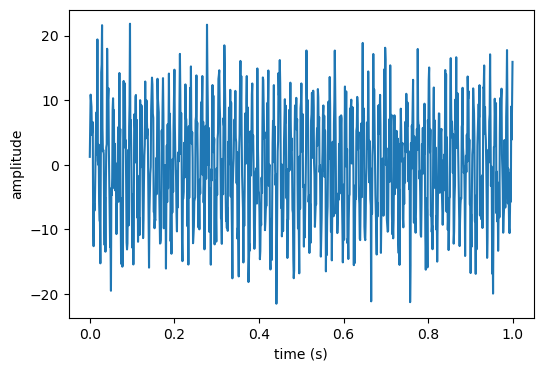

In [2]:
fig, ax = plt.subplots(figsize = [6, 4])
ax.set(ylabel = 'amplitude', xlabel = 'time (s)')
ax.plot(time, x)

We can perform an FFT using our `simple_fft` function, then extract the maximum value to get the signal frequency and height. It is useful to plot the peak we extracted to make sure we have not accidently extracted the wrong value. For now, we will `np.argmax`, which gives us the index of the highest value. In most applications, it is better to use a more sophisticated peak finding method, like `scipy.signal.find_peaks`.

In [3]:
def simple_fft(tsample, x):
    N = len(x)
    f = np.fft.fftfreq(N, d = tsample)
    y = np.fft.fft(x)
    y = np.abs(y) / N
    f, y = f[:N // 2], y[:N // 2] * 2
    return f, y

f, y = simple_fft(tsample, x)

In [4]:
# find peaks: simple method 
max_index = np.argmax(y)
print(f'Amplitude: {y[max_index]}')
print(f'Frequency: {f[max_index]}')

Amplitude: 7.288844323047832
Frequency: 76.0


To plot, we will use a log-log scale. This is often the best way to represent a signal with noise. We drop the DC (frequency = 0) component, since it scales the plot weirdly and does not show up anyway with the logarithmic scale.

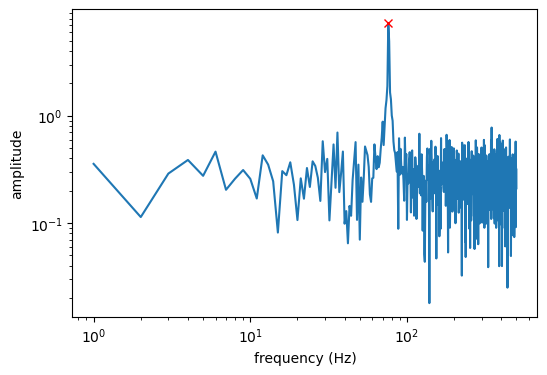

In [5]:
fig, ax = plt.subplots(figsize = [6, 4])
ax.set(ylabel = 'amplitude', xlabel = 'frequency (Hz)')
ax.loglog()
ax.plot(f[1:], y[1:]) 
ax.plot(f[max_index], y[max_index], 'xr')

## Part 2: averaging
Now, imagine you have many data sets to average, but you don't know if the phases are aligned. We can't average the timestreams, because the phase missalignment will disrupt the signal. However, the FFT removes the phase dependence, so we can average the FFT to lower the noise. <b>Note</b>: If we are looking at an electrical signal, it is more common to first convert to power ($V^2$) before averaging. We will ignore this for now.

We will now generate 100 sets of data, each with a random phase offset. If we plot the data, it looks like a bunch of noise without an obvious signal.

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
fsample = 1000 # 1 kHz 
tsample = 1 / fsample
time = np.arange(0, 1, tsample)
frequency = np.random.uniform(0.1, 100)
amplitude = np.random.uniform(0.1, 10)
xs = []
for delta in np.random.uniform(-np.pi, np.pi, 100):
    x = amplitude * np.sin(2 * np.pi * time * frequency + delta)
    noise = 10 * amplitude * np.random.normal(0, 1, len(time))
    x += noise
    xs.append(x)
del frequency, amplitude

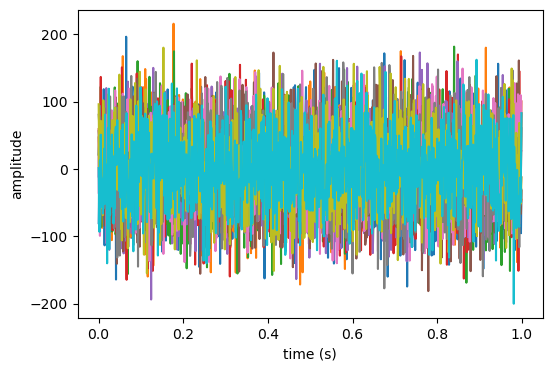

In [7]:
fig, ax = plt.subplots(figsize = [6, 4])
ax.set(ylabel = 'amplitude', xlabel = 'time (s)')
for x in xs[::10]: # Plotting every third dataset so we don't have too many on the same plot 
    ax.plot(time, x)

Next, we will FFT each of the datasets, so we can average the amplitudes while ignoring phase. Note that the frequency data is identical for every dataset, so we only need to keep track of one instance of 'f'.

In [8]:
ys = []
for x in xs:
    f, y = simple_fft(tsample, x)
    ys.append(y)

We can average using np.mean with the 'axis = 0' parameter input.

In [9]:
y_avg = np.mean(ys, axis = 0)

Finally, we can find the peak to get the frequency and amplitude of our signal, and plot the averaged data with one of the original datsets. We see that the signal that was impossible to extract from a single dataset has become clearly distinguishable from noise after averaging. 

In [10]:
max_index = np.argmax(y_avg) 
print(f'Amplitude: {y_avg[max_index]}')
print(f'Frequency: {f[max_index]}')

Amplitude: 5.930839546250326
Frequency: 66.0


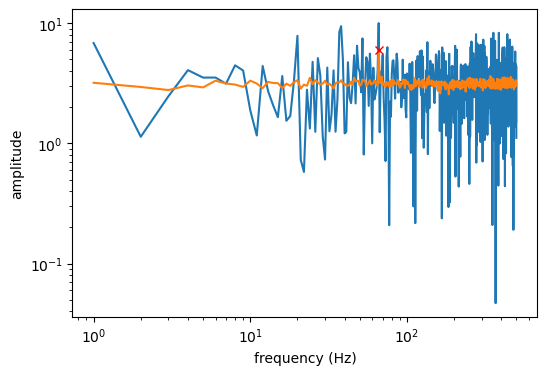

In [11]:
fig, ax = plt.subplots(figsize = [6, 4])
ax.set(ylabel = 'amplitude', xlabel = 'frequency (Hz)')
ax.loglog()
ax.plot(f[1:], ys[0][1:])
ax.plot(f[1:], y_avg[1:])
ax.plot(f[max_index], y_avg[max_index], 'xr')